In [1]:
import numpy as np
import scipy as sci
import jax 
import jax.numpy as jnp
from src.plotting_defaults import plotting_defaults
from hashlib import new
import matplotlib.animation as animation
from matplotlib import style
from matplotlib.animation import FuncAnimation
from random import randint
from scipy.optimize import curve_fit
from scipy.constants import Boltzmann as k
    

Best water_tracks = day3_vid2_Tracks0-3500, index = 1


In [2]:
path = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/"
FILE_LOCATION = path + "glycerine_tracks/glycerine_20.xml"
INDEX_NUM = 0
IMMERSON_LENS = True

In [3]:
def load_data(filename, multi_particle_index = 0):


    if filename.endswith("csv"):
        data = np.genfromtxt(filename, delimiter=',', skip_header=1)
    else:
        from src.xml2csv import xml2csv
        #multi_particle_index used to determine what track to use if there are multiple (usually from the xaml file)
        a = xml2csv(filename, 2)
        data = a[multi_particle_index]
        data = np.array(data)

    return data


#calculate pearson correlation coefficent

@jax.jit
def pearson_corr_coeff(pred, y):
    """
    Calculates pearson coeff.
    """
    pred = jnp.array(pred)
    y = jnp.array(y)    
    R = jnp.corrcoef(pred, y)[1, 0]
    
    return R

@jax.jit
def spearmen_corr_coeff(pred, y):
    
    rank_pred = jnp.argsort(jnp.argsort(pred))
    rank_y = jnp.argsort(jnp.argsort(y))
    val =  pearson_corr_coeff(rank_pred, rank_y)             
    
    return val


def msd_func(data, intervals=1, time_step=1, frame_rate=62.0, immersion=IMMERSON_LENS):
    """
    Data = [b, ] 
    """
    intervals = np.arange(1, len(data))
    data_store = []
    time_step = 1 / frame_rate
    #calculate the intervals between points

    avg_square_dev = []
    std_square_dev = []
    time_interval = []
    if immersion:
        calibration_factor = 0.6*1e-3*0.1/979.3
    else:
        calibration_factor = (0.1*0.001)/1094.4

    data = data * calibration_factor

    for interval in intervals:
        data_store = []
        mean_square_deviation = []


        for i in range(0, len(data), interval):
            if i == 0:
                data_store.append(0)
                mean_square_deviation.append(0)
                

            else:
                
                data_store.append(data[i] - data[i-1])
                
                mean_square_deviation.append((data[i] - data[i-interval])**2)

        time_interval.append(time_step * interval)

        avg_square_dev.append(np.mean ( mean_square_deviation ))

        sigma = (np.std(mean_square_deviation))/(2 * np.sqrt( np.mean(mean_square_deviation)))
        sigma = (np.std(mean_square_deviation)) / np.sqrt(np.shape(mean_square_deviation)[0])
        std_square_dev.append(sigma)
        
    

    return time_interval, avg_square_dev, std_square_dev

def chi_squared(pred, y , pred_error):
    

    chi_sqr = jnp.sum((pred - y) **2 / pred_error**2)
    reduced_chi_sqr = chi_sqr / (len(y) - 1)
    return reduced_chi_sqr


def visc_calc(gradient, diameter, temperature=291):

    
    #eta = (4 * k * temperature) / (3 * np.pi * gradient * diameter)
    temp_grad = gradient / 2 
    eta = (k * temperature) / (6 * np.pi * (diameter/2) * temp_grad)


    return eta


#fit a linear function to the data
#import boltzmann constant
def func(x, a, b):
    return a * x + b

@jax.jit
def calculate_r_squared(pred, y):
    """
    Calculates r squared value
    """
    y_bar = np.mean(y)
    ss_tot = np.sum((y - y_bar)**2)
    ss_res = np.sum((y - pred)**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

In [4]:
data = load_data(filename=FILE_LOCATION, multi_particle_index=INDEX_NUM)
print(f"The number of data points is {len(data)}")

The number of data points is 1128


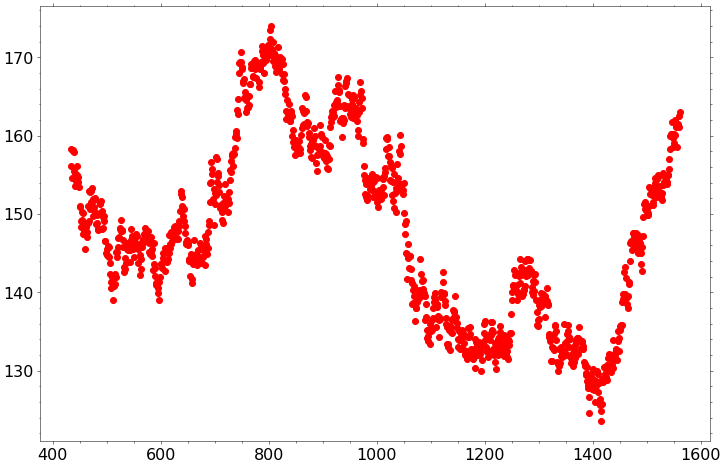

In [5]:
#plot the data
%matplotlib inline
plotting_defaults()
import matplotlib.pyplot as plt
plt.plot(data[:,0], data[:,1], 'ro')

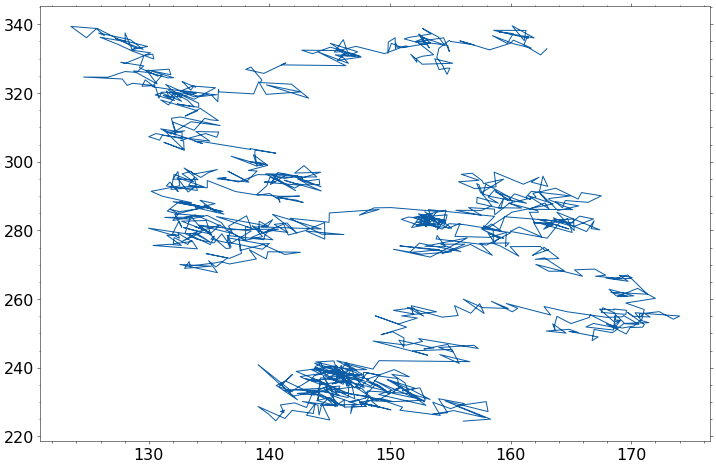

In [6]:
plt.plot(data[:,1], data[:,2])
#plt.line(data[:,1], data[:,2], 'bo')


In [7]:
x = data[:,1]
y = data[:,2]

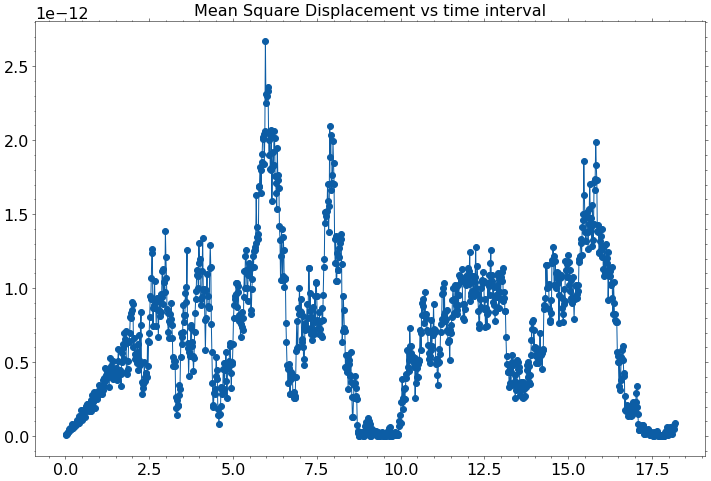

In [8]:
time_interval, avg_square_dev, std_square_dev = msd_func(x)
plotting_defaults()
#plot scatter plot with error bars
#plot title
plt.title("Mean Square Displacement vs time interval")
plt.scatter(time_interval, avg_square_dev)
plt.plot(time_interval, avg_square_dev)

(1127,) (1127,)


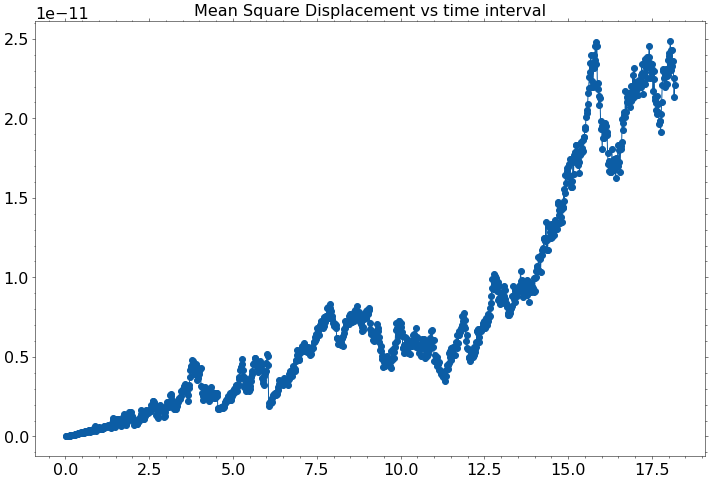

In [9]:
time_interval, avg_square_dev, std_square_dev = msd_func(y)
plotting_defaults()
#plot scatter plot with error bars
#plot title
plt.title("Mean Square Displacement vs time interval")
print(np.shape(time_interval), np.shape(avg_square_dev))
plt.scatter(time_interval, avg_square_dev)
plt.plot(time_interval, avg_square_dev)

The viscosity is 0.0036 +/- 0.00005 Pa.s


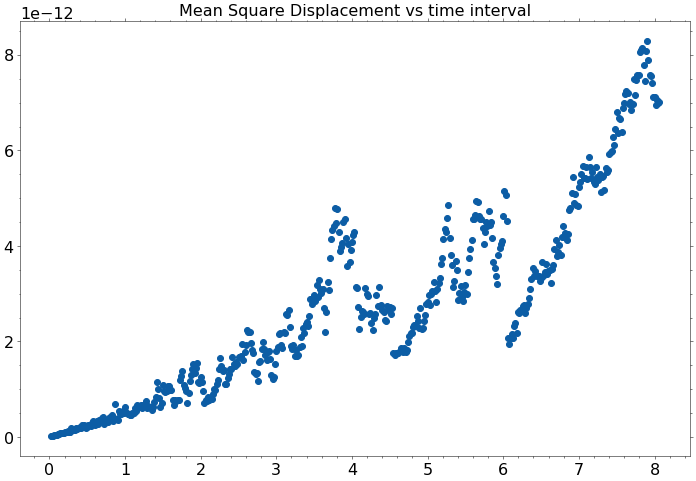

In [10]:
data = load_data(filename=FILE_LOCATION, multi_particle_index=INDEX_NUM)

time_interval, avg_square_dev, std_square_dev = msd_func(y)
plotting_defaults()

temp_time_interval = time_interval[:500]
temp_square = avg_square_dev[:500]
temp_dev = std_square_dev[:500]
#plot scatter plot with error bars
#plot title
plt.title("Mean Square Displacement vs time interval")
plt.scatter(temp_time_interval, temp_square)


popt, pcov = curve_fit(func, temp_time_interval, temp_square, sigma=temp_dev)
eta = visc_calc(popt[0], diameter=0.5e-6)
delta_eta = eta * np.sqrt((pcov[0][0] / popt[0] ** 2) + (0.05/291) ** 2)

print(f"The viscosity is {eta:.4f} +/- {delta_eta:.5f} Pa.s")

D = kT / 6 \pi  \nu r

on

In [11]:
updated_lines = []
updated_lines_1 = []
updated_lines_2 = []
for times in temp_time_interval:
    updated_lines.append(func(times, popt[0], popt[1]))
    updated_lines_1.append(func(times, popt[0] + np.sqrt(pcov[0][0]), popt[1] - np.sqrt(pcov[1][1])))
    updated_lines_2.append(func(times, popt[0] - np.sqrt(pcov[0][0]), popt[1] + np.sqrt(pcov[1][1])))

print(spearmen_corr_coeff(np.array(temp_square), np.array(updated_lines)))
print(pearson_corr_coeff(temp_square, updated_lines))
print(chi_squared(np.array(temp_square), np.array(updated_lines), np.array(temp_dev)))
print(calculate_r_squared(y=np.array(temp_square), pred=np.array(updated_lines)))

0.9307129
0.9042393
0.5747216
0.5188358


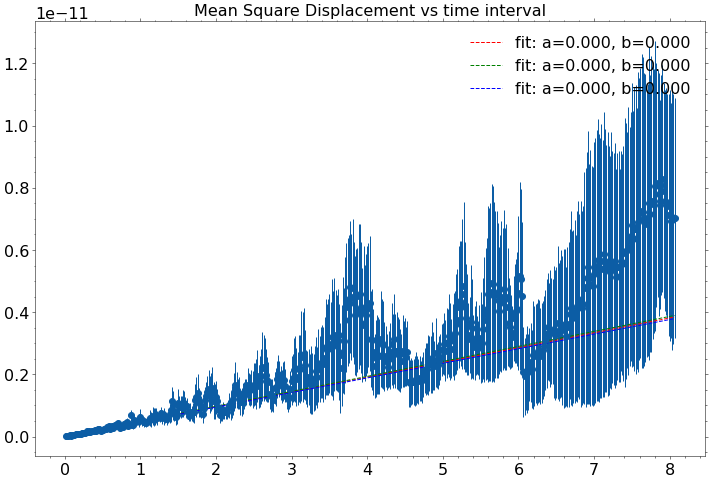

In [12]:
plotting_defaults()
#plot lines with error bars



plt.title("Mean Square Displacement vs time interval")
plt.errorbar(temp_time_interval, temp_square, yerr=temp_dev, fmt="o")

plt.plot(temp_time_interval, updated_lines, 'r--', label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.plot(temp_time_interval, updated_lines_1, 'g--', label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.plot(temp_time_interval, updated_lines_2, 'b--', label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.legend()

<ErrorbarContainer object of 3 artists>

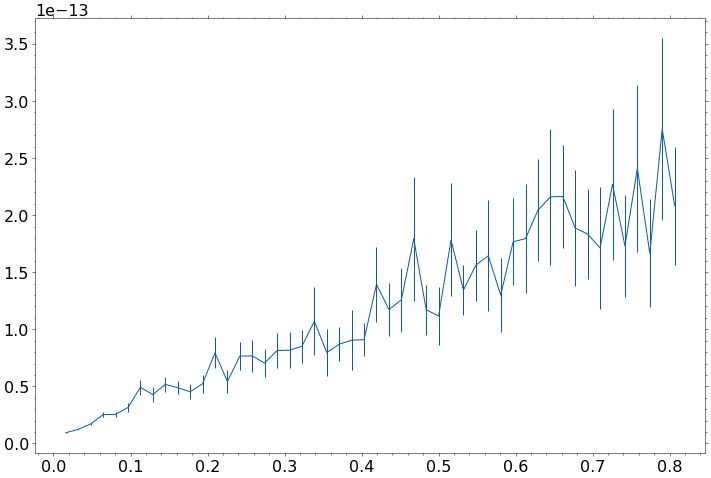

In [13]:
time_interval, avg_square_dev, std_square_dev = msd_func(x)
plt.errorbar(time_interval[:50], avg_square_dev[:50], yerr=std_square_dev[:50])

In [14]:
print(np.shape(x), np.shape(time_interval))

(1128,) (1127,)


In [15]:
import sklearn 
from sklearn.model_selection import train_test_split

time_data, avg_square_dev, _ = msd_func(y)

time = time_data[0:250]
model_y = np.array(avg_square_dev)[0:250]
(X_train, X_test, y_train, y_test) = train_test_split(model_y, time, test_size = .2)

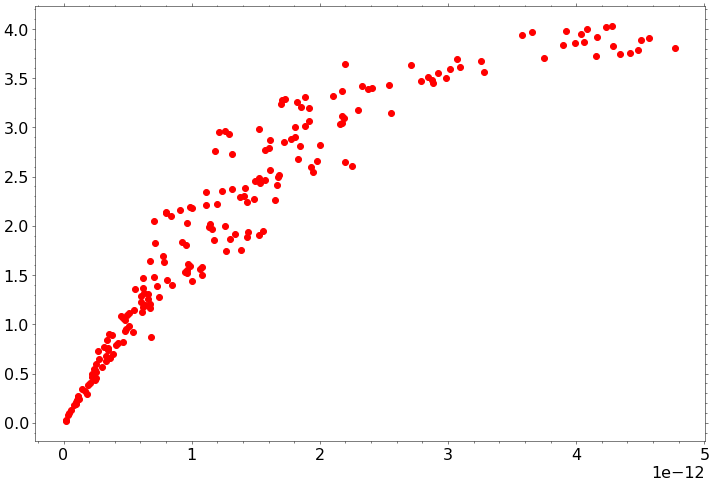

In [16]:
plotting_defaults()
plt.plot(X_train, y_train, 'ro')

In [17]:
from sklearn.dummy import DummyRegressor
dummy_regressor = DummyRegressor()
dummy_regressor.fit(X_train.reshape(-1,1), np.array(y_train).reshape(-1, 1))
dummy_regressor.predict(X_test.reshape(-1,1))
dummy_regressor.score(X_test, y_test)


-0.05920409784380709

In [18]:
from sklearn.gaussian_process import GaussianProcessRegressor

gaussian_reg = GaussianProcessRegressor()
gaussian_reg.fit(X_train.reshape(-1, 1), np.array(y_train).reshape(-1, 1))
gaussian_reg.predict(X_test.reshape(-1,1))
gaussian_reg.score(X_test.reshape(-1, 1), y_test)


-0.05921834157181194

(50, 1) (50,) (50,)
[2.08003235] 3.225806451612903


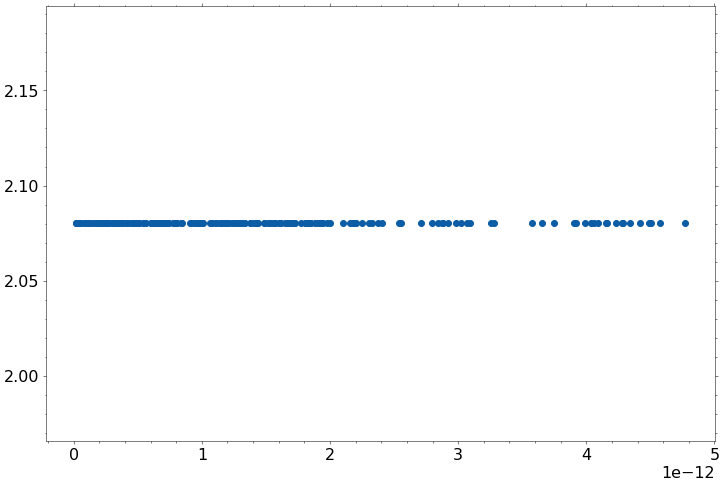

In [22]:
predictions, predictions_std = gaussian_reg.predict(X_test.reshape(-1,1), return_std=True)
fig = plt.figure(figsize=(12,8))
axes = fig.add_subplot(1,1,1)
print(np.shape(predictions), np.shape(predictions_std), np.shape(X_test))
#plt.scatter(X_test, y_test)
#plt.errorbar(X_test, predictions, yerr=predictions_std)
print(predictions[0], y_test[0])

pred_x = gaussian_reg.predict(X_train.reshape(-1,1))
plt.scatter(X_train, pred_x)

In [23]:
np.shape(predictions)

(50, 1)

In [24]:
gaussian_reg.get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel': None,
 'n_restarts_optimizer': 0,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

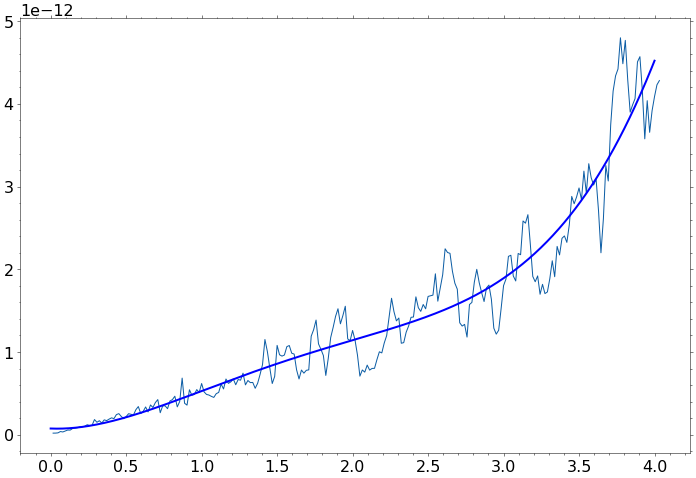

In [25]:
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline


spl = UnivariateSpline(time_data[0:250], avg_square_dev[0:250], k=4)
xs = np.linspace(0, 4, 1000)
spl.set_smoothing_factor(0.1)
plt.plot(time_data[0:250], avg_square_dev[0:250])
plt.plot(xs, spl(xs), 'b', lw=2)


In [ ]:
X_train.max()

4.799597550020146e-12

In [ ]:
spl.get_coeffs()
spl.get_residual()

9.075722922376869e-24

# Glycerol Solution

In [26]:
glycerol_dict = {}

glycerol_dict["20"] = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/glycerine_tracks/glycerine_20.xml"
glycerol_dict["40"] = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/glycerine_tracks/glycerine_40.xml"
glycerol_dict["50"] = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/glycerine_tracks/glycerine_50_2.xml"
glycerol_dict["60"] = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/glycerine_tracks/glycerine_60.xml"
glycerol_dict["0"] = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/cleaned_tracking/day3_vid2_Tracks0-3500.xml"
current_tracks = ["0", "20", "40", "50", "60"]


In [27]:

def analyzer(data, x=True, y=False, num_elem=50, full_analysis=False):

    if x:
        data = data[:, 1]
    else:
        data = data[:, 2]
    time_interval, avg_square_dev, std_square_dev = msd_func(data)
    
    temp_time_interval = time_interval[:num_elem]
    temp_square = avg_square_dev[:num_elem]
    temp_dev = std_square_dev[:num_elem]
    popt, pcov = curve_fit(func, temp_time_interval, temp_square, sigma=temp_dev)
   
    eta = visc_calc(popt[0], diameter=0.5e-6)
    delta_eta = eta * np.sqrt((pcov[0][0] / popt[0] ** 2) + (0.05/291) ** 2)


    if full_analysis:
        updated_lines = []
        updated_lines_1 = []
        updated_lines_2 = []
        for times in temp_time_interval:
            updated_lines.append(func(times, popt[0], popt[1]))
            updated_lines_1.append(func(times, popt[0] + np.sqrt(pcov[0][0]), popt[1] - np.sqrt(pcov[1][1])))
            updated_lines_2.append(func(times, popt[0] - np.sqrt(pcov[0][0]), popt[1] + np.sqrt(pcov[1][1])))

        
        print(f"Spearmen corr coeff {spearmen_corr_coeff(np.array(temp_square), np.array(updated_lines))}")
        print(f"Pearson: {pearson_corr_coeff(temp_square, updated_lines)}")
        print(f"CHI-Squared: {chi_squared(np.array(temp_square), np.array(updated_lines), np.array(temp_dev))}")
        print(f"R_SQUARED: {calculate_r_squared(y=np.array(temp_square), pred=np.array(updated_lines))}")
            







    return eta, delta_eta


In [29]:
indexes_tracks = [3, 2, 1, 0, 1]
data0 =  load_data(filename=glycerol_dict["0"], multi_particle_index=indexes_tracks[0])
data20 = load_data(filename=glycerol_dict["20"], multi_particle_index=indexes_tracks[1])
data40 = load_data(filename=glycerol_dict["40"], multi_particle_index=indexes_tracks[2])
data50 = load_data(filename=glycerol_dict["50"], multi_particle_index=indexes_tracks[3])
data60 = load_data(filename=glycerol_dict["60"], multi_particle_index=indexes_tracks[4])

eta0,  delta0  = analyzer(data0, x=False, num_elem=20)
eta20, delta20 = analyzer(data20, x=True, num_elem=10)
eta40, delta40 = analyzer(data40)
eta50, delta50 = analyzer(data50, x=True, num_elem=10)
eta60, delta60 = analyzer(data60, 25)

result_eta = [eta0,   eta20,   eta40,   eta50,   eta60]
unc_eta    = [delta0, delta20, delta40, delta50, delta60]


In [30]:
print(f" 0: The viscosity is {eta0:.4f} +/- {delta0:.5f} Pa.s")
print(f" 20: The viscosity is {eta20:.4f} +/- {delta20:.5f} Pa.s")
print(f" 40: The viscosity is {eta40:.4f} +/- {delta40:.5f} Pa.s")
print(f" 50: The viscosity is {eta50:.4f} +/- {delta50:.5f} Pa.s")
print(f" 60: The viscosity is {eta60:.4f} +/- {delta60:.5f} Pa.s")

 0: The viscosity is 0.0011 +/- 0.00005 Pa.s
 20: The viscosity is 0.0040 +/- 0.00019 Pa.s
 40: The viscosity is 0.0094 +/- 0.00029 Pa.s
 50: The viscosity is 0.0118 +/- 0.00231 Pa.s
 60: The viscosity is 0.0145 +/- 0.00030 Pa.s


It is important to note that to do this calculation we used the approximation that, alpha the relationship is equal to 1. Although this valid for low visciousity solutions like 0% water. This is not true as we increase the viscousity.

To get a comparision curve, we use data found in:
http://materiel-physique.ens-lyon.fr/Notices/P105GEb_Table%20de%20viscosit%C3%A9%20Glyc%C3%A9rol-eau_ENSLYON.pdf


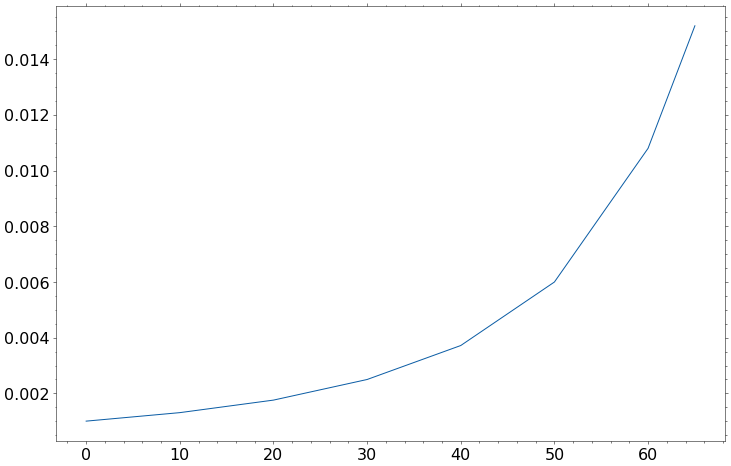

In [31]:
plotting_defaults()
author_x = [0,10,20,30,40,50,60,65,70,75,80,85,90,91,92,93,94,95,96,97,98,99,100]
author_visc = [1.005, 1.31, 1.76, 2.50, 3.72, 6.00, 10.8, 15.2, 22.5, 35.5, 60.1, 109, 219, 259, 310, 367, 437, 523, 624, 765, 939, 1150, 1412]

author_visc = np.array(author_visc)*0.001
plt.plot(author_x[:8], author_visc[:8])

In [32]:
from src.glycerine_conc import glycerine_calc
theoretical_x = np.linspace(0, 60, 20)
glycerine_vol = theoretical_x * 0.01
water_vol = 1 - glycerine_vol
glycerine_array = []
for i in range(len(glycerine_vol)):
    glycerine_array.append(glycerine_calc(water_vol[i], glycerine_vol[i]));


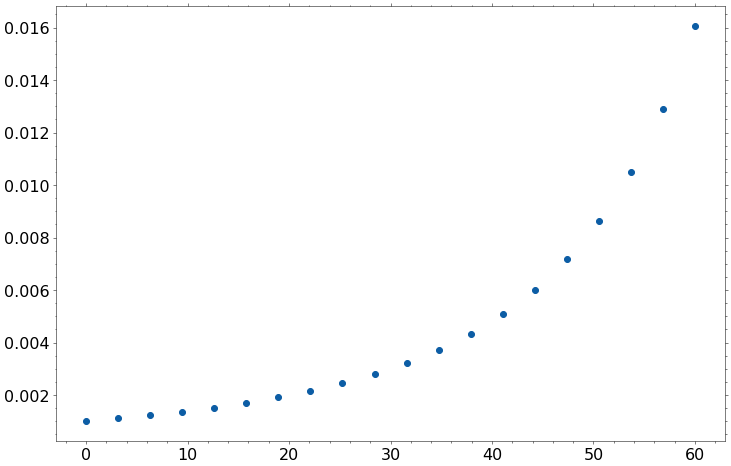

In [33]:
plt.scatter(theoretical_x, glycerine_array)

<ErrorbarContainer object of 3 artists>

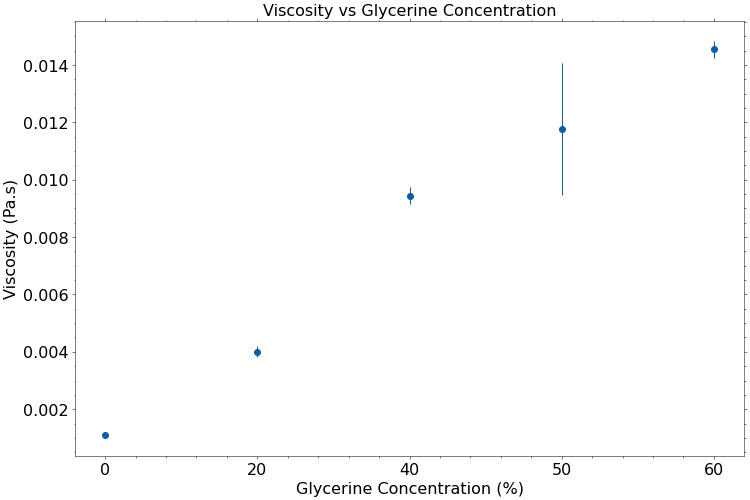

In [34]:
#errorbar plot
plt.xlabel("Glycerine Concentration (%)")
plt.ylabel("Viscosity (Pa.s)")
plt.title("Viscosity vs Glycerine Concentration")
plt.errorbar(current_tracks, result_eta, yerr=unc_eta, fmt='o', label="Data")

# Potential finding

In [35]:
#read the data in:

data = load_data(filename=FILE_LOCATION, multi_particle_index=INDEX_NUM)
print(f"The number of data points is {len(data)}")



The number of data points is 1128


In [36]:
#calculate acceleration and velocity between data point
def accel_cal(data, fps=62.0, immersion=True):
    """Calculate the acceleration between data points"""
    velocity = []
    accel = []
    timestep = 1 / fps
    if immersion:
        calibration_factor = 0.6*1e-3*0.1/979.3
    else:
        calibration_factor = (0.1*0.001)/1094.4
    data = data * calibration_factor


    temp_x = np.array(data) - np.array(data)[0]
    temp_data = []
    for i in range(len(temp_x)):
        temp_data.append(temp_x[i])
        if i > 0:
            vel = (temp_data[-1] - temp_data[-2]) / timestep #this is the velocity at i = 0
            velocity.append(vel)
        if i > 1:
            acc = (velocity[-1] - velocity[-2]) / timestep
            accel.append(acc)
    data = np.array(data)
    velocity = np.array(velocity)
    accel = np.array(accel)

    data = data[:len(accel)]
    velocity = velocity[:len(accel)]
    
    return data, velocity, accel

In [37]:
disp_x, v_x, a_x = accel_cal(x)
disp_y, v_y, a_y = accel_cal(y)

mod_accel = np.sqrt(a_x**2 + a_y**2)
mod_velocity = np.sqrt(v_x**2 + v_y**2)

(array([ 21., 148., 134., 141., 195., 141., 127., 108.,  69.,  42.]),
 array([-1.99330919e-06, -1.68412735e-06, -1.37494550e-06, -1.06576366e-06,
        -7.56581819e-07, -4.47399976e-07, -1.38218133e-07,  1.70963709e-07,
         4.80145552e-07,  7.89327395e-07,  1.09850924e-06]),
 <BarContainer object of 10 artists>)

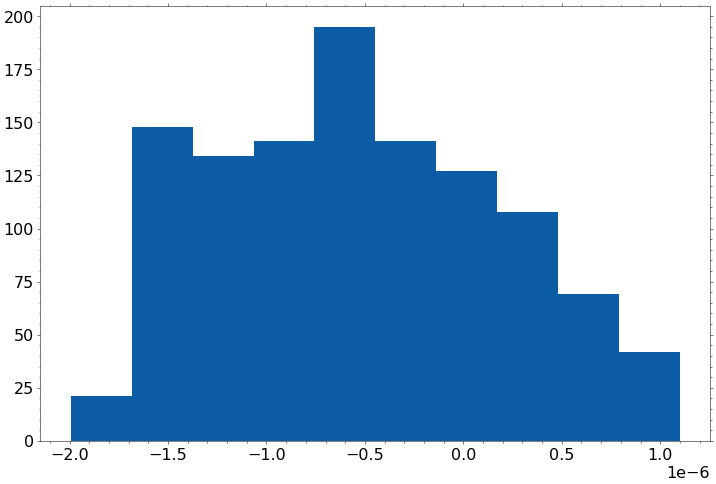

In [38]:
disp_x[0]

centered_x = disp_x - disp_x[0]
plt.hist(centered_x)

calculate the kurtosis and third moment of a data


In [39]:
#calculate the kurtosis of the data
#kurtosis
from scipy.stats import kurtosis
print(kurtosis(centered_x))


-0.9335576077504686


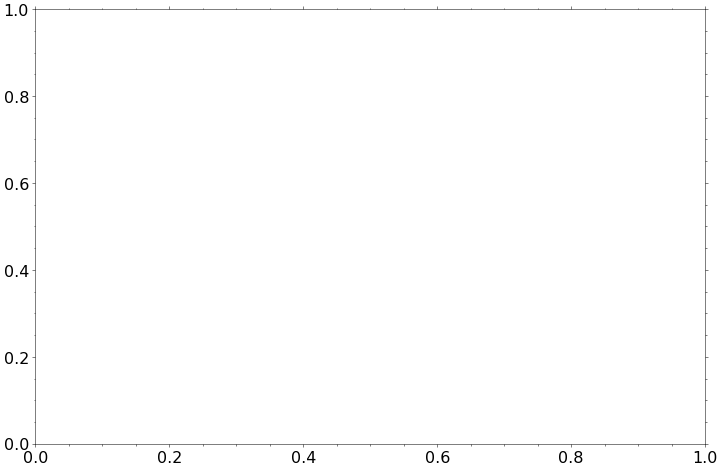

In [40]:
from scipy.stats import gamma
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
a = 1.99
mean, var, skew, kurt = gamma.stats(a, moments='mvsk')


(array([ 21., 148., 134., 141., 195., 141., 127., 108.,  69.,  42.]),
 array([7.56944712e-06, 7.87862897e-06, 8.18781081e-06, 8.49699265e-06,
        8.80617450e-06, 9.11535634e-06, 9.42453818e-06, 9.73372002e-06,
        1.00429019e-05, 1.03520837e-05, 1.06612656e-05]),
 <BarContainer object of 10 artists>)

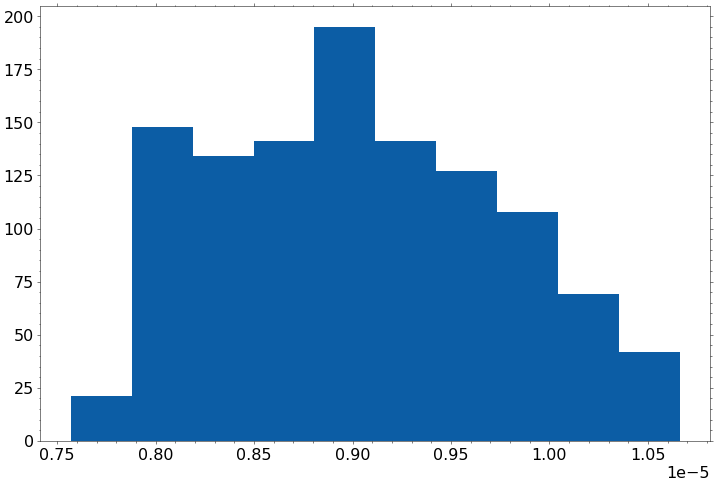

In [41]:
plt.hist(disp_x)

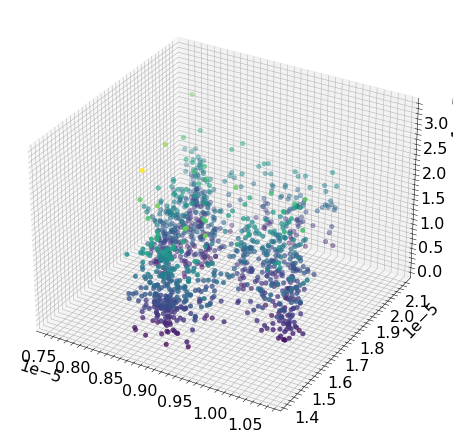

In [42]:
#3D plot of the data
plotting_defaults()



from scipy.stats import kde



fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(disp_x, disp_y, mod_velocity, c=mod_velocity, cmap='viridis', linewidth=0.5)

TypeError: Input z must be 2D, not 1D

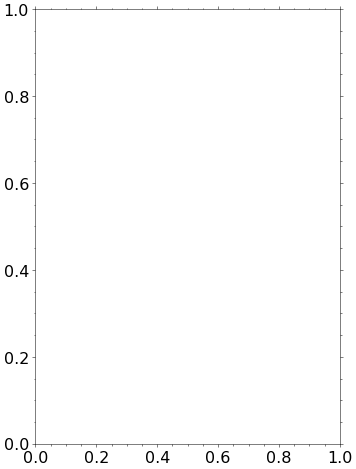

In [45]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(121)
#ax1.pcolormesh(disp_x, disp_y, mod_velocity, cmap='viridis')
ax.contour3D(disp_x, disp_y, mod_velocity, 50, cmap='binary')



# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(disp_x, disp_y, mod_accel, c=mod_accel, cmap='viridis', linewidth=0.5)

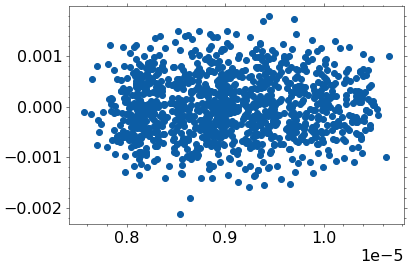

In [ ]:
plotting_defaults()
%matplotlib inline
plt.scatter(disp_x, a_x)

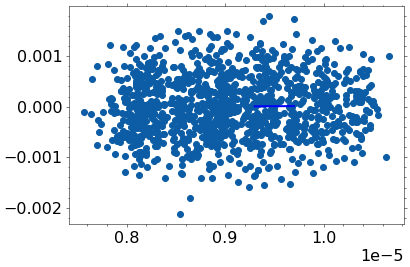

In [ ]:
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
def lexsort(*arrays):
    indexes = np.lexsort(arrays[::-1])
    return tuple((a[indexes] for a in arrays))
disp_x_t, a_x_t = lexsort(disp_x, a_x)
spl = UnivariateSpline(disp_x_t, a_x_t, k=4)

xs = np.linspace(9.3e-6, 9.7e-6, 1000)
spl.set_smoothing_factor(0.5)
plt.scatter(disp_x_t, a_x_t)
plt.plot(xs, spl(xs), 'b', lw=2)

# Lazer zoom zoom


Now we have a lazer we will do some stuff.

In [47]:
#read data in
data_gaussian = load_data(filename=FILE_LOCATION, multi_particle_index=INDEX_NUM)
print(f"The number of data points is {len(data_gaussian)}")

x_gaussian = data_gaussian[:,1]
y_gaussian = data_gaussian[:,2]

time_interval, avg_square_dev, std_square_dev = msd_func(x_gaussian, immersion=True)





The number of data points is 1128


We are only intrested in the first interval and dont really care about the others.

In [48]:
#read text from a file as a numpy array
FILE_LOCATION_TWO = "/home/aavash/Documents/GitHub/Labs/Laser Tweezers/tracking_files/laser_tweezers_one"
FIlE_LOCATION_TWO_LABELS = FILE_LOCATION_TWO + "/current_labels.txt"
CURRENT_POWER_LOC = FILE_LOCATION_TWO + "/laser_power.csv"
data = np.loadtxt(FIlE_LOCATION_TWO_LABELS, delimiter=',', skiprows=0)
#print(data)
print(data.shape)

#create a dictionary of the data
data_dict = {}
power_dict = {}
data = np.genfromtxt(CURRENT_POWER_LOC, delimiter=',', skip_header=1)
for i in range(len(data)):

    power_dict[int(data[i][0])] = data[i][1]

data = np.loadtxt(FIlE_LOCATION_TWO_LABELS, delimiter=',', skiprows=0)


for i in range(len(data)):
    try:
        data_dict[int(data[i][0])] = power_dict.get(data[i][1])
    except:
        pass

data_dict


(18, 2)


{40: 6.85,
 42: 5.52,
 43: 4.84,
 44: 4.21,
 45: 8.38,
 46: 7.92,
 47: 6.97,
 49: 3.56,
 50: 3.35,
 51: 3.18,
 52: 2.91,
 53: 2.56,
 54: 2.28,
 55: 1.62,
 56: 0.97,
 57: 0.57,
 58: 0.3,
 59: 0.01}

In [49]:
def kappa_calculator(data, temperature = 20.0):
    
    data = np.array(data)
    mu, sigma = scipy.stats.norm.fit(data)

    kappa = k * (temperature + 273) / sigma**2

    #not implemented
    kappa_unc = 1
    
    return kappa, kappa_unc


In [69]:
#read in all the files in a folder and load them into an array
import os

temp_x_array, temp_y_array, current_array = [], [], []

rmse_x_array, rmse_y_array = [], []
squared_temp = []


#Kappa vals has the format, [kappa_x, unc_kappa_x, kappa_y, unc_kappa_y]
kappa_vals = []

calibration_factor = 0.6*1e-3*0.1/979.3

potential_x, potential_y = [], []


test_rmse_x = 0
test_rmse_y = 0

i = 0
for filename in os.listdir(FILE_LOCATION_TWO):
    video_code = filename.split("_")[1]
    video_code = video_code[3:]
    
    try:
        video_code = int(video_code)

        if data_dict.get(video_code):
            
            #load data of the file
            temp_filename = FILE_LOCATION_TWO + "/" + filename
            temp_data = load_data(filename=temp_filename, multi_particle_index=0)
            temp_t, temp_x, temp_y = temp_data[:,0], temp_data[:,1], temp_data[:,2]

            #calibration factor of the data
            temp_x = temp_x * calibration_factor
            temp_y = temp_y * calibration_factor
            
            #center the data
            temp_t = temp_t - temp_t[0]
            temp_x = temp_x - temp_x[0]
            temp_y = temp_y - temp_y[0]
            
            #we calculate the kappa of the x and y data
            temp_kappa_x = kappa_calculator(temp_x)
            temp_kappa_y = kappa_calculator(temp_y)

            #append the kappa values to the array
            kappa_vals.append([temp_kappa_x, temp_kappa_y])

            temp_potential_x = (np.array(temp_x) ** 2) * temp_kappa_x[0]
            temp_potential_y = (np.array(temp_y) ** 2) * temp_kappa_y[0]

            potential_x.append([temp_x, temp_potential_x])
            potential_y.append([temp_y, temp_potential_y])

            temp_rmse_x = msd_func(temp_x, time_step=1, frame_rate=63.3, immersion=IMMERSON_LENS)[1][0]
            temp_rmse_y = msd_func(temp_y, time_step=1, frame_rate=63.3, immersion=IMMERSON_LENS)[1][0]

            if i == 2:    
                time_test_x, test_rmse_x, _ = msd_func(temp_x, time_step=1, frame_rate=63.3, immersion=IMMERSON_LENS)
                time_test_y, test_rmse_y, _ = msd_func(temp_y, time_step=1, frame_rate=63.3, immersion=IMMERSON_LENS)



            rmse_x_array.append(temp_rmse_x)
            rmse_y_array.append(temp_rmse_y)
            temp_x_array.append(temp_x), temp_y_array.append(temp_y), current_array.append(data_dict.get(video_code))
            squared_temp.append(np.sqrt(temp_x**2 + temp_y**2))


            i += 1
        else:
            pass
    except:
        pass  



rmse_x_array = np.array(rmse_x_array).flatten()
rmse_y_array = np.array(rmse_y_array).flatten()
array_x_flattened = np.array(temp_x).flatten()
array_y_flattened = np.array(temp_y).flatten()
squared_temp = np.array(squared_temp).flatten()
kappa_vals = np.array(kappa_vals)


/tmp/ipykernel_6173/437260911.py:85: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  squared_temp = np.array(squared_temp).flatten()


/home/aavash/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


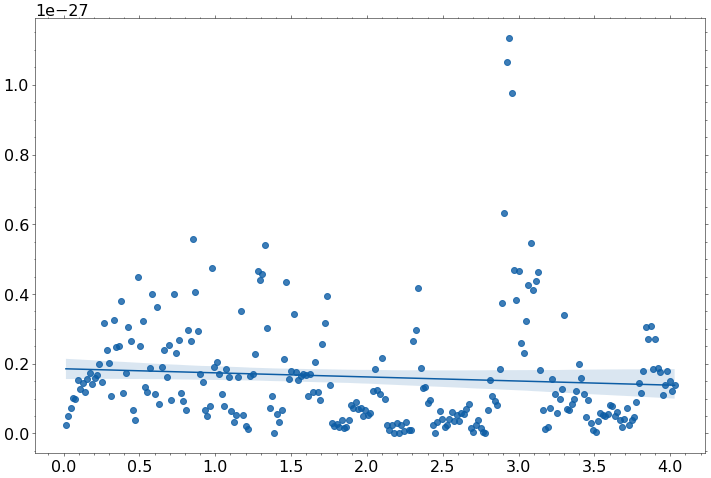

In [70]:

ax = sns.regplot(time_test_x, test_rmse_x);



In [71]:
index_removal = []
for i, elem in enumerate(test_rmse_x):
    if time_test_x[i] > 0.4:
        if  0.1 * 1e-27 < elem < 0.5 * 1e-27:
            pass
        else:
            print(elem, time_test_x[i])
            index_removal.append(i)


time_test_x = np.delete(time_test_x, index_removal)
test_rmse_x = np.delete(test_rmse_x, index_removal) 

6.796129958071224e-29 0.45813586097946296
3.839446625637669e-29 0.4739336492890996
8.387825022374581e-29 0.6319115323854662
9.578077163651739e-29 0.7109004739336494
9.185915432613165e-29 0.7898894154818327
6.622516207163307e-29 0.8056872037914693
5.582806515866736e-28 0.8530805687203793
6.808524395788683e-29 0.9320695102685626
4.880682148389823e-29 0.9478672985781992
7.749965050038573e-29 0.9636650868878358
7.748707703579386e-29 1.0584518167456558
6.395697284416309e-29 1.1058451816745658
3.187015963563755e-29 1.1216429699842023
5.367749469537304e-29 1.137440758293839
5.36024660606389e-29 1.184834123222749
2.2206199329514226e-29 1.2006319115323856
1.3498346753760166e-29 1.2164296998420223
5.413655609438656e-28 1.3270142180094788
7.42315539057638e-29 1.358609794628752
1.541267780223339e-30 1.3902053712480256
5.462404604346946e-29 1.406003159557662
3.144747020915254e-29 1.4218009478672988
6.602688356821281e-29 1.4375987361769353
9.444377218320943e-29 1.6903633491311219
2.8454324030112826e

In [72]:
time_test_x

array([0.01579779, 0.03159558, 0.04739336, 0.06319115, 0.07898894,
       0.09478673, 0.11058452, 0.12638231, 0.14218009, 0.15797788,
       0.17377567, 0.18957346, 0.20537125, 0.22116904, 0.23696682,
       0.25276461, 0.2685624 , 0.28436019, 0.30015798, 0.31595577,
       0.33175355, 0.34755134, 0.36334913, 0.37914692, 0.39494471,
       0.4107425 , 0.42654028, 0.44233807, 0.48973144, 0.50552923,
       0.52132701, 0.5371248 , 0.55292259, 0.56872038, 0.58451817,
       0.60031596, 0.61611374, 0.64770932, 0.66350711, 0.6793049 ,
       0.69510269, 0.72669826, 0.74249605, 0.75829384, 0.77409163,
       0.82148499, 0.83728278, 0.86887836, 0.88467615, 0.90047393,
       0.91627172, 0.97946288, 0.99526066, 1.01105845, 1.02685624,
       1.04265403, 1.07424961, 1.09004739, 1.15323855, 1.16903633,
       1.23222749, 1.24802528, 1.26382306, 1.27962085, 1.29541864,
       1.31121643, 1.34281201, 1.37440758, 1.45339652, 1.46919431,
       1.4849921 , 1.50078989, 1.51658768, 1.53238547, 1.54818

(137,)


Text(0.5, 1.0, 'MSD vs Time (log-log)')

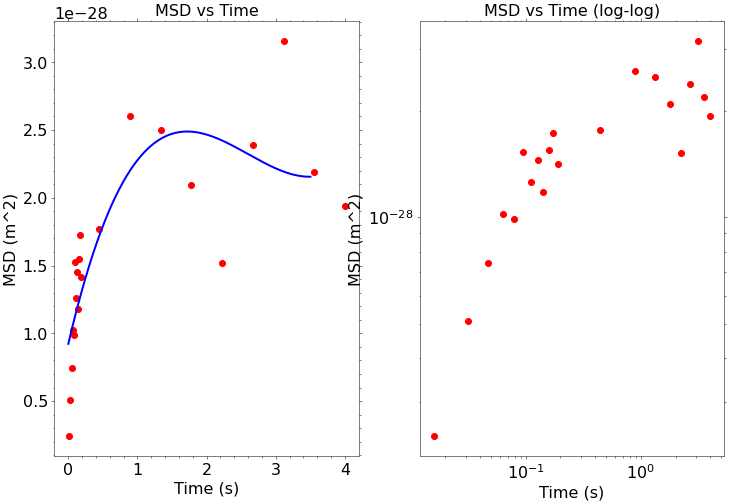

In [103]:
import matplotlib.pyplot as plt
from pandas import plotting
from scipy.interpolate import UnivariateSpline

plotting_defaults()



bins = np.linspace(0.0,4,10)
binned_means = []
print(np.shape(time_test_x))
for i in range(len(bins)-1):

    idx = np.where((np.array(time_test_x)>bins[i]) & (np.array(time_test_x)<bins[i+1]))[0]
    temp_array = test_rmse_x[idx[0]:idx[-1] + 1]
    
    binned_means.append(np.mean(temp_array))




_array_ , _array_2 = [], []

for i, elem in enumerate(time_test_x):
    if elem > 0.2:
        pass
    else:
        _array_.append(elem)
        _array_2.append(test_rmse_x[i])


_array_ = [*_array_, *bins[1:]]
_array_2 = [*_array_2, *binned_means]

#plt.scatter(time_test_x[0:10], test_rmse_x[0:10])

#plt.scatter(bins[1:], binned_means)

#plot two figures in same plot
fig, (ax1,ax2) = plt.subplots(1, 2)



ax1.scatter(_array_, _array_2, color="red")

spl = UnivariateSpline(_array_, _array_2, k=3)
xs = np.linspace(0, 3.5, 1000)
spl.set_smoothing_factor(0.001)
#plt.scatter(time_test_x[0:100], test_rmse_x[0:100])
ax1.plot(xs, spl(xs), 'b', lw=2)


ax2.scatter(_array_, _array_2, color="red")

spl = UnivariateSpline(np.log10(_array_), np.log10(_array_2), k=2)
xs = np.logspace(0, 3.5, 1000)
spl.set_smoothing_factor(0.001)
#plt.scatter(time_test_x[0:100], test_rmse_x[0:100])
#ax2.plot(xs, spl(xs), 'b', lw=2)
ax2.set_yscale("log")
ax2.set_xscale("log")

ax1.set_xlabel("Time (s)")
ax1.set_ylabel("MSD (m^2)")

ax2.set_xlabel("Time (s)")
ax2.set_ylabel("MSD (m^2)")

#ax1 set title
ax1.set_title("MSD vs Time")
ax2.set_title("MSD vs Time (log-log)")

In [54]:
#plt.hist(time_test_x)
histogranp.histogram(test_rmse_x, bins=20)

NameError: name 'histogranp' is not defined

In [55]:
from scipy.stats import binned_statistic

bin_means = binned_statistic(test_rmse_x, time_test_x, statistic='mean', bins=1)[0]
bin_time_means = binned_statistic(time_test_x, time_test_x, statistic='mean', bins=1)[0]
sns.regplot(bin_means, bin_time_means);
ax.set_xscale("log")
ax.set_yscale("log")

NameError: name 'time_test_x' is not defined

In [56]:
binned_statistic(test_rmse_x, test_rmse_x, statistic='mean', bins=30)

BinnedStatisticResult(statistic=array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan,  0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan]), bin_edges=array([-0.5       , -0.46666667, -0.43333333, -0.4       , -0.36666667,
       -0.33333333, -0.3       , -0.26666667, -0.23333333, -0.2       ,
       -0.16666667, -0.13333333, -0.1       , -0.06666667, -0.03333333,
        0.        ,  0.03333333,  0.06666667,  0.1       ,  0.13333333,
        0.16666667,  0.2       ,  0.23333333,  0.26666667,  0.3       ,
        0.33333333,  0.36666667,  0.4       ,  0.43333333,  0.46666667,
        0.5       ]), binnumber=array([16]))

/home/aavash/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


DeviceArray(-0.22556607, dtype=float32)

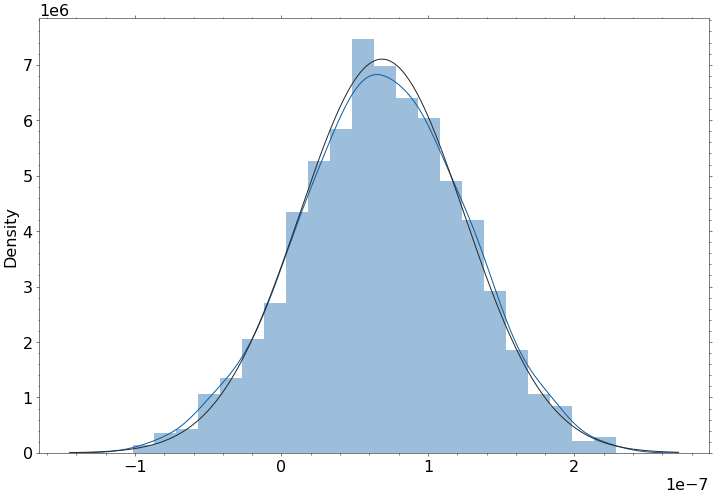

In [57]:

#numpy flatten array
import numpy as np
import seaborn as sns
from scipy.stats import norm

# Generate simulated data
n_samples = 100
rng = np.random.RandomState(0)
data = rng.standard_normal(n_samples)

# Fit Gaussian distribution and plot
sns.distplot(array_x_flattened, fit=norm, kde=True)
#sns.distplot(array_y_flattened, fit=norm, kde=False)

import scipy
mu, sigma = scipy.stats.norm.fit(array_x_flattened)


covariance_matrix = np.cov(array_x_flattened, y = array_y_flattened)
covariance_matrix

pearson_corr_coeff(array_x_flattened, array_y_flattened)

In [58]:
print(f"mean {mu} and sigma {sigma}")



mean 6.861323506423006e-08 and sigma 5.6180090768377606e-08


As we know the data is distributed normally, we can extract the the value of Kappa, as we know

$N(x | \mu, \sigma ^2) = \frac{1}{\sqrt{2 \pi \sigma ^2}}exp(-\frac{1}{2\sigma^2}(x - \mu)^2)$

we also know that the Gaussian PDF for our distribution is theoretically,
$ C exp (\frac{-\kappa}{2 k_b T}(x - x_o)^2)$

therefore,

$\frac{\kappa}{2k_bT} = \frac{1}{2\sigma^2}$

In [59]:
print(np.shape(kappa_vals))

print(np.shape(kappa_vals[:, 0, 0]))
kappa_vals[:, 0, 0]

(0,)


IndexError: too many indices for array: array is 1-dimensional, but 3 were indexed

In [60]:
# plotting_defaults()
# plt.scatter(current_array, kappa_vals[:, 0, 0], color="green", label="kappa_x")

# plt.scatter(current_array, kappa_vals[:, 1, 0], color='red', label="kappa_y")



/home/aavash/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/aavash/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


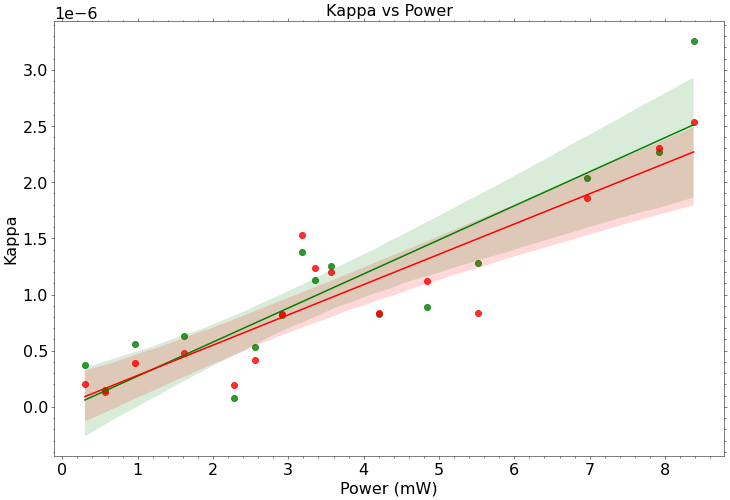

In [104]:
ax = sns.regplot(current_array, kappa_vals[:, 0, 0], color="green", label="kappa_x", scatter=True)
ax = sns.regplot(current_array, kappa_vals[:, 1, 0], color='red', label="kappa_y", scatter=True)
ax.set_xlabel("Power (mW)")
ax.set_ylabel("Kappa")
ax.set_title("Kappa vs Power")
ax.set_label("")


Uncertainities in the measurements found by boostrapping with 1000 parameters and 95% confidence intervals are shown

Now we find the potential landscape for x and y

In [62]:
plotting_defaults()
plt.scatter(potential_x[0][0],potential_x[0][1])
plt.scatter(potential_y[0][0],potential_y[0][1])

IndexError: list index out of range

In [63]:
np.shape(kappa_vals)

(0,)

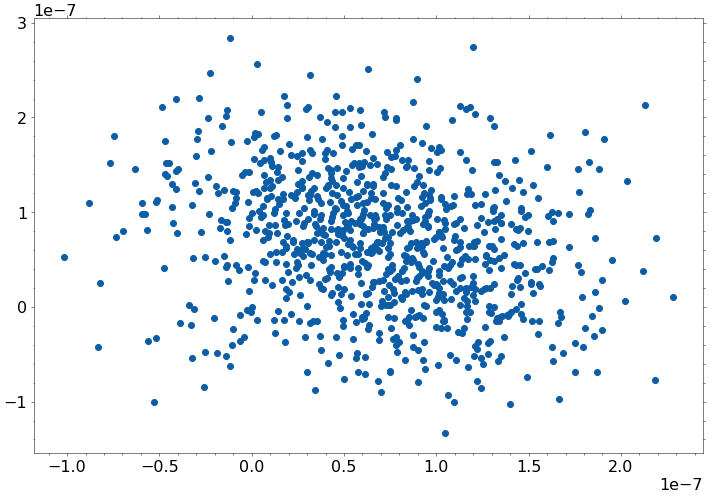

In [64]:
plt.plot(array_x_flattened, array_y_flattened, 'o')

<AxesSubplot:>

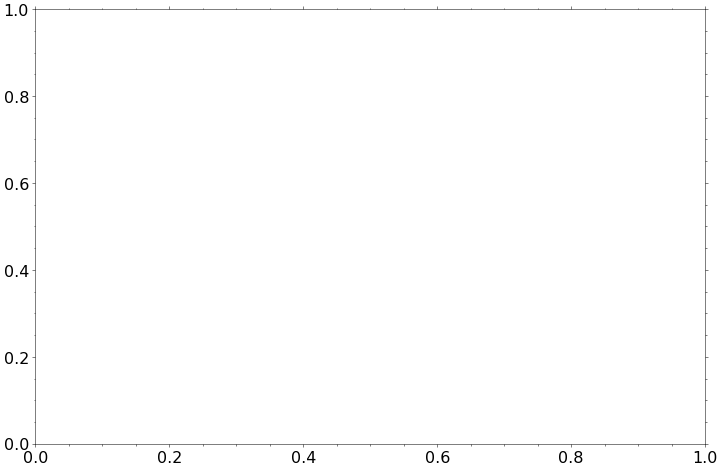

In [65]:
sns.scatterplot(x=current_array, y=rmse_x_array)
sns.scatterplot(x=current_array, y=rmse_y_array)

In [66]:
np.shape(current_array), np.shape(squared_temp)

((0,), (0,))

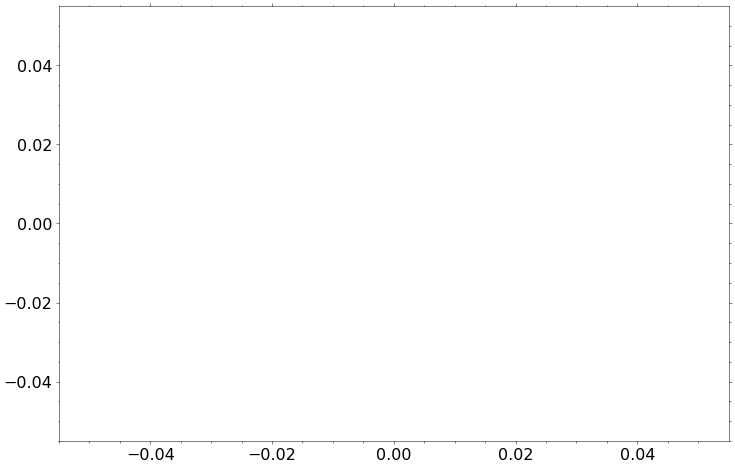

In [67]:
plt.plot(current_array, squared_temp, 'o')

/home/aavash/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


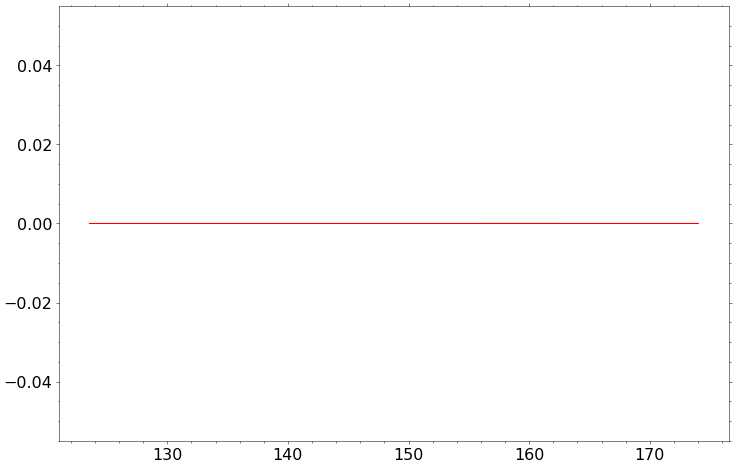

In [105]:
#We fit the <delta x> to a gaussian.

from scipy.optimize import curve_fit
def gaussian(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

#fit a guassian
popt, pcov = curve_fit(gaussian, x_gaussian[:1127], avg_square_dev, p0=[1, 0, 1])


#plot a gaussian with the fitted parameters
plt.plot(x_gaussian[:1127], gaussian(x_gaussian[:1127], *popt), 'r-')



## Finding X(t)


We want to plot, 
\
$<\Delta x(t)^2> = A( 1- exp(\frac{\kappa \tau}{\gamma}))$

We know kappa for each value of the current, so for each current, we can calculate x(t)  vs t. 


Plotting, 
$ \frac{\gamma}{\kappa \tau}  log( - <\Delta x(t)^2> / A)  = 1 $
